In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# import the necessary package
from data_generator import DataGenerator
from myutils import Utils

from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score

datagenerator = DataGenerator()
utils = Utils()

In [55]:
# Data preparation

df_train = pd.read_csv('./datasets/fraud_ds_train.csv', header=None)
df_test = pd.read_csv('./datasets/fraud_ds_test.csv', header=None)
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

# print(df_train.head())
# print(df_test.head())

# Extract Features and Labels

X_train, y_train = df_train.iloc[:,0:-1].values, df_train.iloc[:,-1].values
X_test, y_test = df_test.iloc[:,0:-1].values, df_test.iloc[:,-1].values

print('X_train size:', X_train.shape)
print('X_test size:', X_test.shape)

print('y_train size:', y_train.shape)
print('y_test size:', y_test.shape)

X_train size: (199364, 29)
X_test size: (85443, 29)
y_train size: (199364,)
y_test size: (85443,)


In [77]:
df_train.iloc[:,-1].value_counts(normalize=True)

0    0.998275
1    0.001725
Name: 29, dtype: float64

In [56]:
from baseline.PyOD import PYOD
from baseline.DevNet.run import DevNet
from baseline.Supervised import supervised
from baseline.DAGMM.run import DAGMM # Unsup
from baseline.DevNet.run import DevNet

model_dict = {'IForest': PYOD, 'DevNet':DevNet,}
dataset_list = ['credit_card']
# save the results
df_AUCROC = pd.DataFrame(data=None, index=dataset_list, columns = model_dict.keys())
df_AUCPR = pd.DataFrame(data=None, index=dataset_list, columns = model_dict.keys())

In [57]:
# seed for reproducible results
seed = 42

for name, clf in model_dict.items():
    # model initialization
    if name == 'DevNet':
        clf = clf(seed=seed, model_name=name, save_suffix='test') # DevNet use early stopping to save the model parameter
    else:
        clf = clf(seed=seed, model_name=name)

    # training, for unsupervised models the y label will be discarded
    clf = clf.fit(X_train=X_train, y_train=y_train)

    # output predicted anomaly score on testing set
    if name =="DAGMM":
        score = clf.predict_score(X_train, X_test)
    else:
        score = clf.predict_score(X_test)

    # evaluation
    result = utils.metric(y_true=y_test, y_score=score)
    # save results
    df_AUCROC.loc[dataset_list[0], name] = result['aucroc']
    df_AUCPR.loc[dataset_list[0], name] = result['aucpr']
    

best param: None
Training size: 199364, No. outliers: 344
Epoch 1/50
20/20 [==============================] - 3s 11ms/step - loss: 2.6765
Epoch 2/50
20/20 [==============================] - 0s 10ms/step - loss: 2.5782
Epoch 3/50
20/20 [==============================] - 0s 11ms/step - loss: 2.4928
Epoch 4/50
20/20 [==============================] - 0s 10ms/step - loss: 2.3995
Epoch 5/50
20/20 [==============================] - 0s 11ms/step - loss: 2.2987
Epoch 6/50
20/20 [==============================] - 0s 10ms/step - loss: 2.1948
Epoch 7/50
20/20 [==============================] - 0s 10ms/step - loss: 2.0814
Epoch 8/50
20/20 [==============================] - 0s 11ms/step - loss: 1.9653
Epoch 9/50
20/20 [==============================] - 0s 11ms/step - loss: 1.8473
Epoch 10/50
20/20 [==============================] - 0s 10ms/step - loss: 1.7081
Epoch 11/50
20/20 [==============================] - 0s 10ms/step - loss: 1.5771
Epoch 12/50
20/20 [==============================] - 0s 10ms

In [58]:
print(np.max(score))
print(np.min(score))

6.6377764
-1.1056802


In [62]:
score[:,0].shape

(85443,)

In [63]:
score_series = pd.Series(score[:,0])

(array([7.611e+03, 5.875e+04, 1.463e+04, 2.813e+03, 1.268e+03, 2.290e+02,
        9.000e+00, 1.300e+01, 2.900e+01, 9.100e+01]),
 array([-1.1056802 , -0.33133456,  0.4430111 ,  1.2173568 ,  1.9917024 ,
         2.766048  ,  3.5403938 ,  4.314739  ,  5.089085  ,  5.8634305 ,
         6.6377764 ], dtype=float32),
 <BarContainer object of 10 artists>)

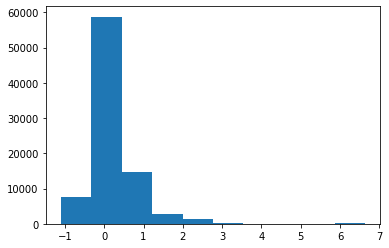

In [64]:
plt.hist(score)

# Evaluate AUC-ROC

# Calculate the best threshold by Gmeans

In [65]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, score)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=1.369155, G-Mean=0.950


# Calculate the best threshold by Youden's J statistic

In [66]:

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=1.369155


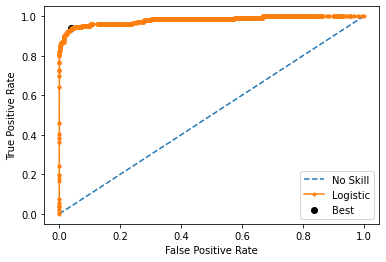

In [67]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

# Probability to Class

In [68]:
y_pred = np.where(score > best_thresh, 1, 0)

In [69]:
# Printing performance metrics 
metrics_values = [['Accuracy', accuracy_score(y_test, y_pred)],
                 ['Precision', precision_score(y_test, y_pred)],
                 ['Recall', recall_score(y_test, y_pred)],
                 ['F1_score', f1_score(y_test, y_pred)]]
metrics_values_df = pd.DataFrame(metrics_values, columns=['Metrics', 'Result'])
metrics_values_df

,Metrics,Result
0,Accuracy,0.961764
1,Precision,0.040648
2,Recall,0.932432
3,F1_score,0.077900


# Confusion matrix

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Fraud')]

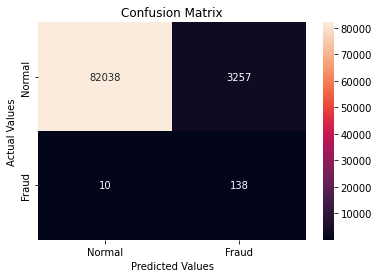

In [70]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualization
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'Fraud'])
ax.yaxis.set_ticklabels(['Normal', 'Fraud'])

# Evaluate AUC-PR

# Choosing the best threshold by using F-1 / F-measure score

Best Threshold=3.691841, F-Score=0.814


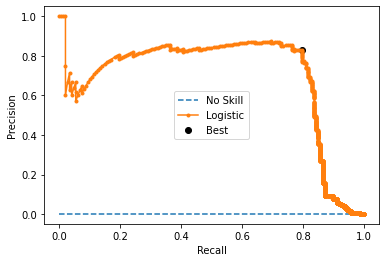

In [71]:
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, score)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall + 1e-9)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [72]:
best_thresh = thresholds[ix]
y_pred = np.where(score > best_thresh, 1, 0)

In [73]:
# Printing performance metrics 
metrics_values = [['Accuracy', accuracy_score(y_test, y_pred)],
                 ['Precision', precision_score(y_test, y_pred)],
                 ['Recall', recall_score(y_test, y_pred)],
                 ['F1_score', f1_score(y_test, y_pred)]]
metrics_values_df = pd.DataFrame(metrics_values, columns=['Metrics', 'Result'])
metrics_values_df

,Metrics,Result
0,Accuracy,0.999356
1,Precision,0.829787
2,Recall,0.790541
3,F1_score,0.809689


[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Fraud')]

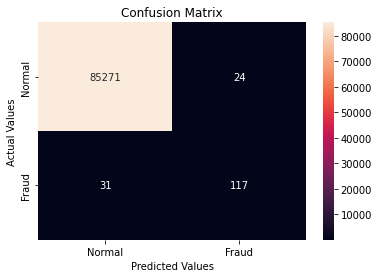

In [74]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualization
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'Fraud'])
ax.yaxis.set_ticklabels(['Normal', 'Fraud'])